In [1]:
KB = {
    "reset password": "To reset your password, go to Settings > Security > Reset Password.",
    "forgot password": "Click 'Forgot Password' on the login screen to receive a reset link.",
    "change email": "You can update your registered email from Settings > Account.",
    "api key": "You can generate a new API key from the Developer Dashboard > API Keys.",
    "upgrade plan": "You can upgrade your plan anytime from Billing > Subscription.",
    "cancel subscription": "You can cancel your subscription from Billing > Manage Subscription.",
    "refund policy": "Refunds are available within 7 days for annual plans.",
    "login issue": "Try clearing cookies or resetting your password if login fails.",
    "account locked": "Your account gets locked after 5 failed attempts. Wait 15 min or reset password.",
    "delete account": "To delete your account permanently, contact support@example.com.",
    "contact support": "You can reach human support at support@example.com.",
}


In [2]:
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint

model = HuggingFaceEndpoint(
    repo_id='meta-llama/Meta-Llama-3-8B-Instruct',
    task='text-generation',
)
llm=ChatHuggingFace(llm=model)

c:\Users\Ankit\Desktop\Personal_adaptive_customer_support\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from typing import Optional,TypedDict
class AgentState(TypedDict):
    user_input: str
    persona: Optional[str] = None
    kb_answer: Optional[str] = None
    final_response: Optional[str] = None
    escalate: Optional[bool] = False


In [20]:
def detect_persona(state: dict) -> dict:
    user_msg = state['user_input']
    
    prompt = f"""
    Classify the user message into one persona:
    - technical expert
    - frustrated user
    - business exec
    
    Only return the label.
    Message: {user_msg}
    """
    
    persona = llm.invoke(prompt).content.lower()
    state['persona'] = persona
    return state

In [ ]:
def retrieve_kb(state: dict) -> dict:
    msg = state["user_input"].lower().strip()
    
    for key, value in KB.items():
        if key.lower() == msg:
            state["kb_answer"] = value
            return state
        
        
        if key.lower() in msg:
            state["kb_answer"] = value
            return state
        
        key_words = key.lower().split()
        if all(w in msg for w in key_words):
            state["kb_answer"] = value
            return state
    
    state["kb_answer"] = "No direct match found."
    return state

In [ ]:
def adapt_response(state: dict) -> dict:
    prompt = f"""
    User message: {state['user_input']}
    Persona: {state['persona']}
    KB answer: {state['kb_answer']}
    
    Write a response in the tone of the persona:
    - technical expert: short + technical
    - frustrated user: empathetic, calm, helpful
    - business exec: formal, high-level
    """
    
    state['final_response'] = llm.invoke(prompt).content
    return state

In [22]:
def escalate(state: dict) -> dict:
    if state["persona"] == "frustrated user" and state["kb_answer"] == "No direct match found.":
        state["escalate"] = True
        state["final_response"] = f"I'm escalating this to a human agent.\nContext: {state['user_input']}"
    else:
        state["escalate"] = False
    return state

In [24]:
from langgraph.graph import StateGraph, END

graph = StateGraph(dict)

graph.add_node("persona", detect_persona)
graph.add_node("retrieve", retrieve_kb)
graph.add_node("adapt", adapt_response)
graph.add_node("escalate", escalate)

graph.set_entry_point("persona")

graph.add_edge("persona", "retrieve")
graph.add_edge("retrieve", "adapt")
graph.add_edge("adapt", "escalate")
graph.add_edge("escalate", END)

agent = graph.compile()


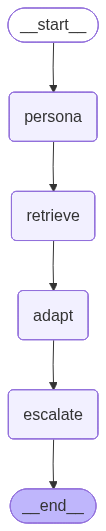

In [25]:
agent

In [28]:
state1 = {
    "user_input": "forgot password",
    "persona": None,
    "kb_answer": None,
    "final_response": None,
    "escalate": False
}


In [29]:
result = agent.invoke(state1)

print("Persona:", result["persona"])
print("KB Answer:", result["kb_answer"])
print("Final:", result["final_response"])
print("Escalate:", result["escalate"])


Persona: frustrated user
KB Answer: Click 'Forgot Password' on the login screen to receive a reset link.
Final: None
Escalate: False


In [33]:
state2 = {
    "user_input": "I'm so angry! Why is your service so slow?",
    "persona": None,
    "kb_answer": None,
    "final_response": None,
    "escalate": False
}

In [34]:
result2 = agent.invoke(state2)

print("Persona:", result2["persona"])
print("KB Answer:", result2["kb_answer"])
print("Final:", result2["final_response"])
print("Escalate:", result2["escalate"])


Persona: frustrated user
KB Answer: No direct match found.
Final: I'm escalating this to a human agent.
Context: I'm so angry! Why is your service so slow?
Escalate: True
